In [1]:
from furax.obs.stokes import StokesIQU
import jax
import jax.numpy as jnp
from furax.obs.landscapes import Stokes
import numpy as np
from furax.obs.operators import (
    CMBOperator, DustOperator, MixingMatrixOperator
)
import healpy as hp
from furax.core._blocks import BlockDiagonalOperator, BlockRowOperator, BlockColumnOperator
from furax import HomothetyOperator
import operator
from hwp_models import *
import jaxopt
from functools import partial
from furax.obs import negative_log_likelihood
from fgbuster.observation_helpers import _jysr2rj, _rj2cmb
import pysm3
from pysm3 import units as u
import matplotlib.pyplot as plt
import tools as tl 

cuda_plugin_extension is not found.


In [2]:
NSIDE   = 32
NFREQ   = 10
ANGLE_INCIDENCE = 5.0
shape = (hp.nside2npix(NSIDE),)
keys = ["MF1", "MF2", "UHF1", "UHF2"]
frequency_channels = [92.0, 148.0, 225.5, 286.5]
frequency_dict = dict(zip(keys, frequency_channels))

dust_nu0 = 148.
synchrotron_nu0 = None
best_params = {"beta_dust": 1.54}

In [4]:
def Operator(params):
    Op_list = []

    for nu_x, (key, value) in enumerate(frequency_dict.items()):
        freq    = value
        epsilon = 1.0
        phi     = 0.
        bp_arrays_uKCMB = tl.get_bp_uKCMB(freq, NFREQ)

        AOp     = tl.eval_A(params, dust_nu0,bp_arrays_uKCMB[0], in_structure)
    
        ListOp = StokesToListOperator(axis=0, in_structure=AOp.out_structure())
        hwp_list = []
        if 'UHF' in key:
            thickness = thicknesses_HF[3]
            alpha_2 = angles_HF[4]
        
        else: 
            thickness = thicknesses[3]
            alpha_2 = angles_MF[4]

        for nu in bp_arrays_uKCMB[0]:
            # Create HWP operator for this frequency
            hwp_list.append(MixedStokesOperator.create(
                shape=shape,
                stokes='IQU',
                frequency=nu,
                angleIncidence=ANGLE_INCIDENCE,
                epsilon=epsilon,
                phi=phi, 
                thickness=thickness,
                alpha_2=alpha_2
            ))
            
        HDiag = BlockDiagonalOperator([hwp_list[i] for i in range(NFREQ)])
        # print(f'HWP in structure: {HDiag.out_structure()}')
        BP = bp_arrays_uKCMB[1]
        # BP[nfreq//2] = 1.0
        
        # print(bp_arrays_uKCMB[0][nfreq//2])
        STRUCT = StokesIQU.structure_for(shape=(hp.nside2npix(NSIDE),), dtype=np.float64)
        Bandpass_RowOp = BlockRowOperator([HomothetyOperator(BP[i]/np.sum(BP),STRUCT) for i in range (BP.size)])

        Op = Bandpass_RowOp  @ HDiag @ ListOp  @ AOp
        Op_list.append(Op)

    OpBlock     = BlockColumnOperator([Op_list[i] for i in range (len(Op_list))])
    struct = OpBlock.out_structure()
    # print(struct)
    StokesOp    = ListToStokesOperator(axis=0, in_structure=OpBlock.out_structure())
    BMA = StokesOp @ OpBlock

    return BMA

In [5]:
cmb_sky = pysm3.Sky(nside=NSIDE, preset_strings=["c1"], output_unit=u.uK_CMB)
dust_sky = pysm3.Sky(nside=NSIDE, preset_strings=["d0"], output_unit=u.uK_CMB)

cmb_maps = np.zeros((len(frequency_channels), 3,hp.nside2npix(NSIDE)))
dust_maps = np.zeros((len(frequency_channels), 3,hp.nside2npix(NSIDE)))

for i, f in enumerate(frequency_channels):
    cmb_maps[i] = cmb_sky.get_emission(f * u.GHz )
    dust_maps[i] = dust_sky.get_emission(f * u.GHz )


cmb_input = cmb_sky.get_emission(148 * u.GHz )
dust_input = dust_sky.get_emission(148 * u.GHz )


s_cmb   = Stokes.from_stokes(I=cmb_input[0]*0, Q=cmb_input[1], U=cmb_input[2])
s_dust  = Stokes.from_stokes(I=dust_input[0]*0, Q=dust_input[1], U=dust_input[2])

s= {'cmb':s_cmb, 'dust':s_dust}

in_structure = s_cmb.structure_for(s_cmb.shape,)
print(in_structure)

StokesIQU(i=ShapeDtypeStruct(shape=(12288,), dtype=float64), q=ShapeDtypeStruct(shape=(12288,), dtype=float64), u=ShapeDtypeStruct(shape=(12288,), dtype=float64))


In [6]:
BMA_op = Operator(best_params)
c4s4_maps = BMA_op(s)

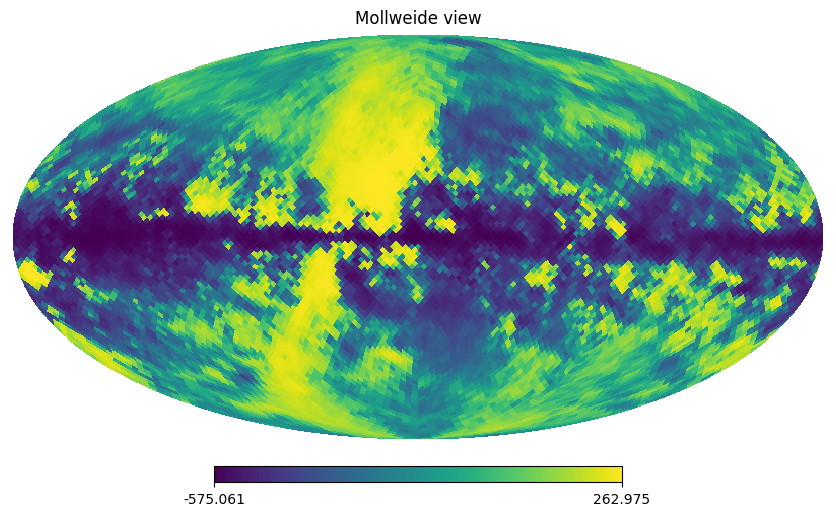

In [7]:
hp.mollview(c4s4_maps.q[3], norm='hist')

In [8]:
invN = HomothetyOperator(jnp.ones(1), _in_structure=BMA_op.T.in_structure())
DND = invN(c4s4_maps) @ c4s4_maps

In [13]:
#@jax.jit  # JIT compilation for performance
def negative_log_prob(params, d):
    """
    Compute negative log-likelihood for component separation.
    """
    # Create component operators with current parameter values
    BMA = Operator(params)

    # Compute likelihood using the marginalized form:
    # L = (A^T N^-1 d)^T (A^T N^-1 A)^-1 (A^T N^-1 d)
    x = (BMA.T @ invN)(d)  # A^T N^-1 d
    likelihood = jax.tree.map(lambda a, b: a.T @ b, x, (BMA.T @ invN @ BMA).I(x))
    summed_log_prob = jax.tree.reduce(operator.add, likelihood)

    return -summed_log_prob  # Return negative for minimization

In [14]:

beta_dust_values = jnp.linspace(1.5, 1.6, 10)  

plt.figure(figsize=(12, 7))

results = {}

print("Computing NLL vs. beta_dust...")

nll_values = []

# Loop only over beta_dust
for beta_dust in beta_dust_values:
    params = {"beta_dust": beta_dust, "temp_dust": 20.0}
    nll = negative_log_prob(params, d=c4s4_maps)  
    nll_values.append(nll)

nll_values = jnp.array(nll_values)

# Find best beta_dust
best_idx = jnp.argmin(nll_values)
best_beta = beta_dust_values[best_idx]
best_nll = nll_values[best_idx]

results = {
    "beta_dust": beta_dust_values,
    "nll": nll_values,
    "best_beta": best_beta,
    "best_nll": best_nll,
}



print(f"Best beta_dust = {best_beta:.4f}, Min NLL = {best_nll:.4f}")


Computing NLL vs. beta_dust...
Best beta_dust = 1.5444, Min NLL = -89195984.7740


<Figure size 1200x700 with 0 Axes>

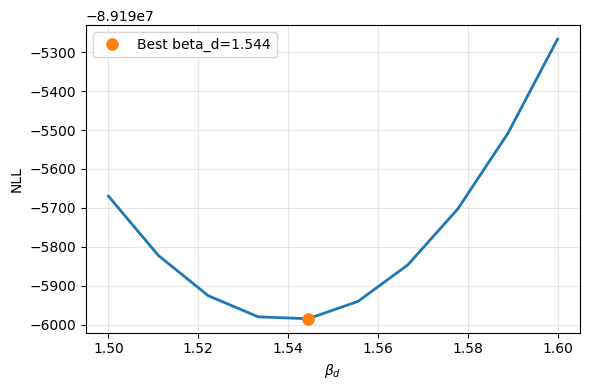

In [15]:

plt.figure(figsize=(6,4))
plt.plot(beta_dust_values, nll_values, linewidth=2)
plt.plot(best_beta, best_nll, 'o', markersize=8, label=f"Best beta_d={best_beta:.3f}")
plt.xlabel(r"$\beta_d$")
plt.ylabel("NLL")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()


plt.show()